In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

In [2]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


In [5]:
dftrain.dtypes

sex                    object
age                   float64
n_siblings_spouses      int64
parch                   int64
fare                  float64
class                  object
deck                   object
embark_town            object
alone                  object
dtype: object

In [22]:
for n in dftrain.dtypes.unique():
  print(list(dftrain.dtypes[dftrain.dtypes == n].index), str(n)[:3])

['sex', 'class', 'deck', 'embark_town', 'alone'] obj
['age', 'fare'] flo
['n_siblings_spouses', 'parch'] int


In [50]:
for n in dftrain.columns:
  print(n ,dftrain[n].nunique())

sex 2
age 76
n_siblings_spouses 7
parch 6
fare 216
class 3
deck 8
embark_town 4
alone 2


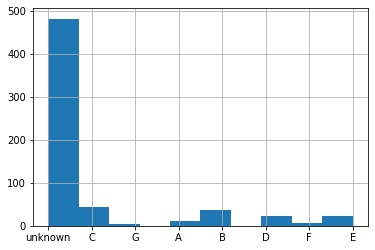

In [59]:
dftrain['deck'].hist()

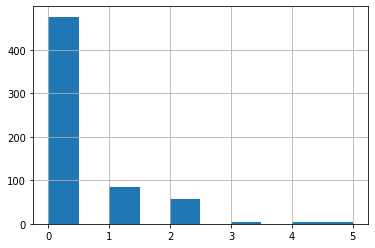

In [60]:
dftrain['parch'].hist()

In [24]:
# without fixes to column feature
feat_col = []

feat_col.append(tf.feature_column.numeric_column('fare', dtype=tf.float32))

age_col = tf.feature_column.numeric_column('age', dtype=tf.float64)
age_bucket = tf.feature_column.bucketized_column(age_col, boundaries=[18,25,35,45,60])
feat_col.append(tf.feature_column.indicator_column(age_bucket))

obj = ['sex', 'class', 'deck', 'embark_town', 'alone','n_siblings_spouses', 'parch']
for name in obj:
  vocab = dftrain[name].unique()
  name_col = tf.feature_column.categorical_column_with_vocabulary_list(name, vocab)
  feat_col.append(tf.feature_column.indicator_column(name_col))

In [73]:

# with fixes to column features
# embed deck and parch feature
# cross sex with age 

feat_col = []

feat_col.append(tf.feature_column.numeric_column('fare', dtype=tf.float32))

age_col = tf.feature_column.numeric_column('age', dtype=tf.float32)
age_bucket = tf.feature_column.bucketized_column(age_col, boundaries=[18,25,35,45,60])
feat_col.append(age_bucket)


lis = ['parch', 'deck']
for name in lis:
  vocab = dftrain[name].unique()
  p_col = tf.feature_column.categorical_column_with_vocabulary_list(name, vocab)
  p_embed = tf.feature_column.embedding_column(p_col, dimension=2)
  feat_col.append(p_embed)

lis1 = ['embark_town', 'alone','n_siblings_spouses', 'class']

for name in lis1:
  vocab = dftrain[name].unique()
  p_col = tf.feature_column.categorical_column_with_vocabulary_list(name, vocab)
  feat_col.append(tf.feature_column.indicator_column(p_col))


# 1 - exp(-k*(k-1)/2/hash_bucket_size) cross equation, k = categories

sex_vocab = dftrain['sex'].unique()
sex_col = tf.feature_column.categorical_column_with_vocabulary_list('sex', sex_vocab)


cross_feat = tf.feature_column.crossed_column(keys =[sex_col, age_bucket], hash_bucket_size= 5)
print(cross_feat)


vocab = dftrain['sex'].unique()
Sex = tf.feature_column.categorical_column_with_vocabulary_list('sex', vocab)

crossed_feature = tf.feature_column.crossed_column([age_bucket, Sex], hash_bucket_size=500)
crossed_feature = tf.feature_column.indicator_column(crossed_feature)
feat_col.append(crossed_feature)

CrossedColumn(keys=(VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 35, 45, 60))), hash_bucket_size=5, hash_key=None)


In [74]:
def make_input(df_data, df_label, epochs = 3, shuffle=True, batch_size = 5):
  def input_fn():
    ds = tf.data.Dataset.from_tensor_slices((dict(df_data), df_label))
    if shuffle:
      ds.shuffle(1000)
    return ds.batch(batch_size).repeat(epochs)
  return input_fn


In [75]:
train_input = make_input(dftrain, y_train)
eval_input = make_input(dfeval, y_eval, shuffle=False)

In [76]:
classifier = tf.estimator.LinearClassifier( feature_columns=feat_col, n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz_364r83', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [77]:
feat_col

[NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 BucketizedColumn(source_column=NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(18, 25, 35, 45, 60)),
 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f0198e60588>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=2, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f0196f86b38>, ckpt_to_load_from=None

In [78]:
classifier.train(train_input)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpz_364r83/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO

In [79]:
result = classifier.evaluate(eval_input)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-22T22:53:48Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpz_364r83/model.ckpt-378
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.92888s
INFO:tensorflow:Finished evaluation at 2020-06-22-22:53:49
INFO:tensorflow:Saving dict for global step 378: accuracy = 0.79924244, accuracy

In [80]:
result

{'accuracy': 0.79924244,
 'accuracy_baseline': 0.625,
 'auc': 0.83578205,
 'auc_precision_recall': 0.7905945,
 'average_loss': 0.47509935,
 'global_step': 378,
 'label/mean': 0.375,
 'loss': 0.47499022,
 'precision': 0.7395833,
 'prediction/mean': 0.36511558,
 'recall': 0.7171717}